<a href="https://colab.research.google.com/github/kurage404/Quantum_Algorithm/blob/main/My_Grover_Alg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Groverのアルゴリズムをフルスクラッチで書いてみた

タイトル通り、グローバーのアルゴリズムを実装してみました、という感じです。  
筆者は、量子計算も、なんなら大学数学も初心者なので、  
間違っている、または見にくい箇所があるかもしれません。  

コードもお世辞にも読みやすいとは言えませんが、
それでも何かの役に立てれば幸いです。  

参考：  
https://dojo.qulacs.org/ja/latest/notebooks/8.2_Grovers_algorithm.html  
https://qiskit.org/textbook/ja/ch-algorithms/grover.html  
原論文：  
https://arxiv.org/pdf/quant-ph/9605043.pdf

## <font color= "#5e5">環境構築のあれこれ</font>
このGoogle Colab上で動作させるために必要なものをインストールします。

この実装では、QulacsというPythonの疑似量子ゲートシュミレーターを主に利用しています。

In [1]:
### 環境構築 ###
## Qulacsのインストール
!pip install qulacs
## Qulacsのエラーが正常に出力されるようになります。
!pip3 install wurlitzer
%load_ext wurlitzer
## ライブラリのインポート
import matplotlib.pyplot as plt
import numpy as np
import time 
import random
from qulacs import QuantumState
from qulacs.state import inner_product
from qulacs import QuantumCircuit
from qulacs.gate import to_matrix_gate
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H #アダマールゲート
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算

     |████████████████████████████████| 451 kB 5.4 MB/s 


<font color= "#5e5">
----------------------------------------------------------------------------------------------------------------------------------------------------------------
</font>

## <font color= "#5e5">各関数定義</font>
グローバーのアルゴリズムに必要な処理を関数として定義します。

以下は定義する関数のリストです。
*   初期化・初期状態設定
*   ゲート作用関数
*   オラクル U_w 作用
*   反転 U_s 作用
*   グラフへプロット(可視化)
*   なんちゃってAES
*   暗号鍵・平文設定
*   暗号鍵最適化
*   文字列変換

### <font color= "#99f">初期状態・評価用設定(quantum_(ans_)setup)</font>
初期状態と内積を評価するために必要な処理に関する関数です。

quantum_setup()は、nqubit個の量子状態を生成し、0で初期化します。  

quantum_ans_setup()は、内積評価のための処理です。

In [2]:
### 初期化・初期状態設定 ###
def quantum_setup(nqubits):
    ## QuantumState()でnqubit個の量子状態を生成
    ## set_zero_stateで|00...0>に初期化
    state = QuantumState(nqubits)
    state.set_zero_state()

    return state
    
def quantum_ans_setup(nqubits, bitint):
    ## 内積評価のために準備する処理
    answer_state = QuantumState(nqubits)
    answer_state.set_computational_basis(bitint)

    return answer_state

<font color= "#99f">
----------------------------------------------------------------------------------------------------------------------------------------------------------------
</font>

### <font color= "#99f">各ゲート作用(.*_gate)</font>
H(アダマール)ゲートとCZゲートを作用するための関数です。

H(アダマール)ゲートは、量子を重ね合わせの状態にするゲートです。  

CZゲートはコントロールビットが1の時にターゲットビットにZゲートを適用するゲートです。

In [3]:
### ゲート作用関数 ###
def h_gate(nqubits, Hadamard=0):
    ## H(アダマール)ゲート
    for i in range(nqubits):
        Hadamard.add_gate(H(i))
    return Hadamard

def cz_gate(nqubits, s=0, bitlist=[0]):
    ## CZゲート
    if(bitlist == [0]):
        bitlist = [0] * nqubits
    CZ = to_matrix_gate(Z(nqubits-1-s)) 
    for i in range(nqubits-1):
        control_index = i
        control_with_value = bitlist[i]
        CZ.add_control_qubit(control_index, control_with_value)
    return CZ

<font color= "#99f">
----------------------------------------------------------------------------------------------------------------------------------------------------------------
</font>

### <font color= "#99f">オラクル U_w 作用(take_U_w)</font>
オラクル U_w 作用に関する関数です。

オラクル(神の啓示)です。答えかどうかがわかります。  
正確には解であるものを反転します。

In [4]:
### オラクル U_w 作用 ###
def take_U_w(nqubits,s,bitlist):
    ## 
    U_w = QuantumCircuit(nqubits)
    CZ = cz_gate(nqubits, s, bitlist)
    U_w.add_gate(CZ)
    return U_w

#### コラム：qubitとbit

---  
bit は右側が小さくて、左側が大きい。  
例：  
　　2進数 1010 = 1×8 + 0×4 + 1×2 + 0×1 = 9

対してqubitは左側が小さくて、右側が大きい。  
例：  
　　\|1010\> = 0101 =  0×8 + 1×4 + 0×2 + 1×1 = 5
  
これらの違いから、添え字に注意しなければならない。  
Qlacsはqubitに、bitと同じように左から0とついているが、  
ゲートシュミレーターによっては右からのものもあるので、気をつけましょう。  
また、qubitとbitで大きさを比較するときとかも、実装に注意が必要かも?(1敗)

---

<font color= "#99f">
----------------------------------------------------------------------------------------------------------------------------------------------------------------
</font>

### <font color= "#99f">反転 U_s 作用(take_U_s)</font>
反転 U_s 作用に関する関数です。

U_wでは、解を反転しましたが、今度は全体を反転します。

In [5]:
### 反転 U_s 作用 ###
def take_U_s(nqubits):
    U_s = QuantumCircuit(nqubits)
    U_s = h_gate(nqubits,U_s)
    ## 2|0><0| - I の実装
    U_s.add_gate(to_matrix_gate(RZ(nqubits-1, 2*np.pi))) # 位相(-1)を全ての状態に付与
    U_s.add_gate( X(nqubits-1) )
    ## 全てのi-th qubitが0の場合だけZゲートを作用させる
    CZ = cz_gate(nqubits)
    U_s.add_gate(CZ)
    U_s.add_gate(X(nqubits-1)) 
    U_s = h_gate(nqubits,U_s)
    return U_s

<font color= "#99f">
----------------------------------------------------------------------------------------------------------------------------------------------------------------
</font>

### <font color= "#99f">グラフへプロット(可視化)(show_distribution)</font>
グラフへプロット(可視化)するための関数です。

視覚的にわかりやすくするために、グラフで表示します。

In [6]:
## 係数の絶対値の分布をプロットする関数
def show_distribution(state,nqubits):
    plt.bar([i for i in range(pow(2,nqubits))], abs(state.get_vector()))
    plt.show()

<font color= "#99f">
----------------------------------------------------------------------------------------------------------------------------------------------------------------
</font>

### <font color= "#99f">なんちゃってAES(quasi_aes)</font>
なんちゃってAESの関数です。

なんちゃってなのでかなり適当に実装してますが、
いつか時間のある時にでも直したいですね...

AES暗号というのは一般的に
- sub_bytes
- shift_rows
- mix_columns
- add_round_key

という４つの暗号/復号化処理をします。  
AESの暗号鍵は 128,182,256 bitのいずれかとしていますが、  
このプログラムは(なんちゃってなので)鍵長を特に定めずに、  
足りない分はループして使ってます。  


In [7]:
### なんちゃってAES ###
def quasi_aes(message, direction, key):
    if (direction == 0):
        ## 暗号化
        message = sub_bytes(message, direction)
        message = shift_rows(message, direction)
        message = mix_columns(message, direction)
        message = add_round_key(message, key)
        crypto_message = message
    elif (direction == 1):
        ## 復号化
        message = add_round_key(message, key)
        message = mix_columns(message, direction)
        message = shift_rows(message, direction)
        message = sub_bytes(message, direction)
        crypto_message = message
    else:
        crypto_message = message

    return crypto_message

def sub_bytes(message, direction):
    ## 換字表（Sボックス）による１バイト単位の置換。
    ## なんちゃってなので割愛(そのまま返す)
    return message

def shift_rows(message, direction):
    ## 1文字単位の行を一定規則でシフトする。
    c = 0
    if direction==0:
        mbit = []
        for i in message:
            mbit.append(format(ord(i),'08b'))
            bits = mbit[c]
            mbit[c] = bits[1:len(bits)] + bits[:1]
            c += 1
    elif direction==1:
        mbit = message
        for i in message:
            bits = mbit[c]
            mbit[c] = bits[len(bits)-1:] + bits[0:len(bits)-1]
            c += 1
    else:
        mbit = message
            
    return mbit


def mix_columns(message, direction):
    ## ビット演算による１文字単位の行列変換。
    ## 反転処理(0 <=> max, 1 <=> max-1, 2 <=> max-2, ...)
    if direction==0:
        message.reverse()
    elif direction==1:
        message.reverse()

    return message


def add_round_key(mbit, key):
    ## ラウンド鍵とのXORをとる。
    c = 0
    mbitlen = []
    for i in message:
        mbitlen.append(len(mbit[c]))
        c += 1
    mbit = ''.join(mbit)
    c = 0
    result = []
    for i in mbit:
        result.append(xor(int(i),int(key[c%len(key)])))
        c += 1
    mbit = []
    c=0
    for i in range(len(mbitlen)):
        mbit.append(''.join(result[c:c+mbitlen[i]]))
        c = c + mbitlen[i]

    return mbit

## xorの演算を行います
def xor(a,b):
    if bool(a) != bool(b):
        return '1'
    else:
        return '0'


<font color= "#99f">
----------------------------------------------------------------------------------------------------------------------------------------------------------------
</font>

### <font color= "#99f">暗号鍵・平文設定(get_crypto_setting)</font>
暗号鍵や平文を設定するための関数です。

暗号を2進数にしたり、平文を返します。

In [8]:
### 暗号鍵(password)・平文(message)設定 ###
def get_crypto_setting(password):
    ## 平文を変えたい場合は、下の"(ダブルカンマで囲まれた文字列)"を書き換えてください
    message = "「平文」が欲しいか？欲しけれりゃくれてやる。解いてみろ。この世の<はじまり>をそこに置いてきた。 by Mr.グローバー"
    ## パスワードの文字列を2進数に変換
    passbit = []
    passlen = []
    c = 0
    for i in password:
        passbit.append(format(ord(i),'08b'))
        passlen.append(len(passbit[c]))
        c += 1
    if(len(passbit)>1):
        passbit = ''.join(passbit)
    elif(len(passbit)==1):
        passbit = passbit[0]
    ## 変換した2進数と平文を渡す
    return passbit,message,passlen

<font color= "#99f">
----------------------------------------------------------------------------------------------------------------------------------------------------------------
</font>

### <font color= "#99f">暗号鍵最適化(optimisation_key)</font>
暗号鍵を最適化するための関数です。

U_w,U_sに渡すものを最適化します。

In [9]:
### 暗号鍵(password)・平文(message)設定 ###
def optimisation_key(passbit):
    nqubits = len(passbit)
    bitint = int(passbit,2)
    s = 0 
    bitlist = [1] * nqubits
    a = 1
    l = 2**nqubits - bitint + 1
    if (l >= ((2**(nqubits-1))-1)):
        l = l - (2**(nqubits-1))
        s = nqubits - 1
    for i in range(nqubits-1,0,-1):
        if (l >= 2**i):
            l = l - 2**i
            bitlist[i] = 0

    return nqubits, bitlist, s, bitint 

<font color= "#99f">
----------------------------------------------------------------------------------------------------------------------------------------------------------------
</font>

### <font color= "#99f">文字列変換(get_crypto_message)</font>
bit列を文字列に変換します。

In [10]:
def get_crypto_message(crypto_bitmessage):
    crypto_message = []
    for i in crypto_bitmessage:
        moji = '0b'+i
        crypto_message.append(chr(int(moji, 2)))
    crypto_message = ''.join(crypto_message)
    return crypto_message

<font color= "#99f">
----------------------------------------------------------------------------------------------------------------------------------------------------------------
</font>

<font color= "#5e5">
----------------------------------------------------------------------------------------------------------------------------------------------------------------
</font>

## <font color= "#5e5">実行してみる</font>
グローバーのアルゴリズムを実行し体験します。

**************************************************
password: "L"
message:　"「平文」が欲しいか？欲しけれりゃくれてやる。解いてみろ。この世の<はじまり>をそこに置いてきた。 by Mr.グローバー"
password(bit):　01001100
message(crypto): "㋪╥჈⶗㉲O÷Sá×SⓁᆎⳗ㏞⑍Ჿ㡏ځ⤲͇㦍ۛ⤸ʽ㡅偡㏎④ᄴⵗ㏬␉ᆸ⋶ⱉ㈄◍ᇼⵕ㎌◃ဤⵕ㎰⑫㐇鱝㠏گ⤦ኡᆨⱗ洩⿴ⓝ"
**************************************************
1


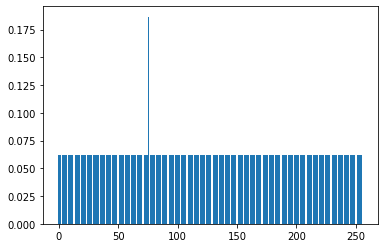

2


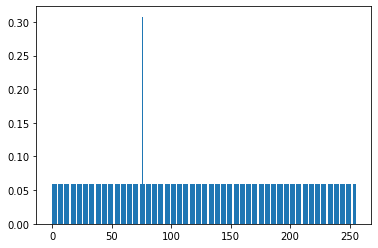

3


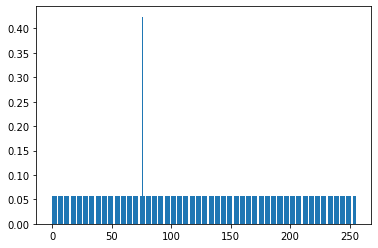

4


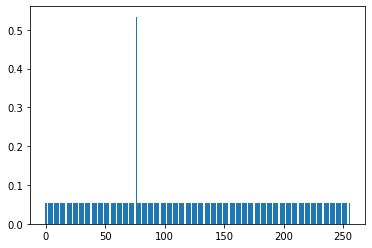

5


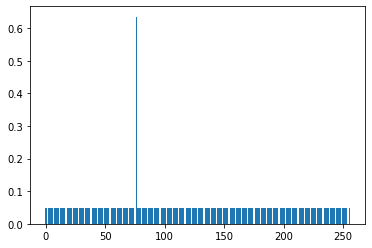

6


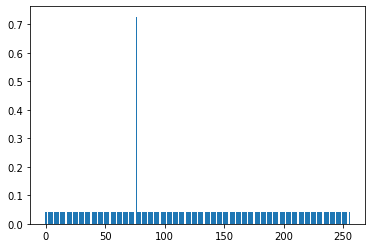

7


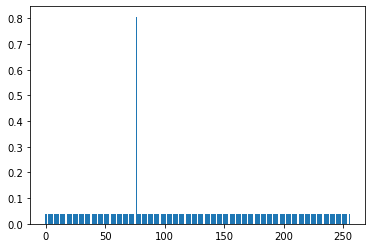

8


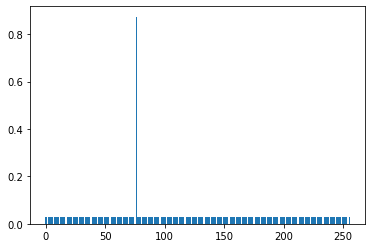

9


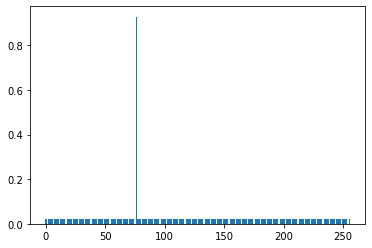

10


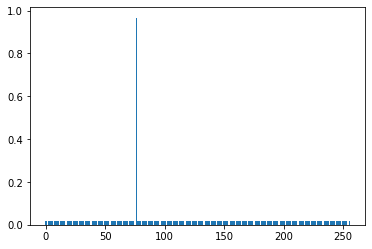

11


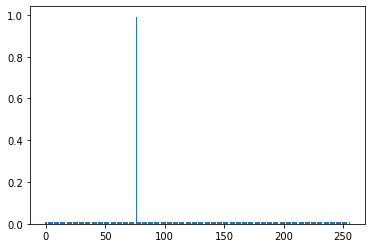

12


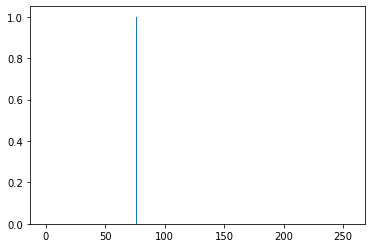

13


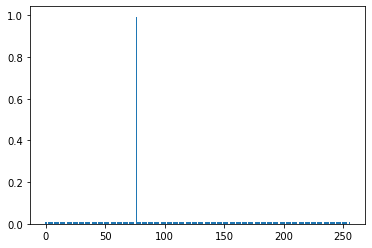

14


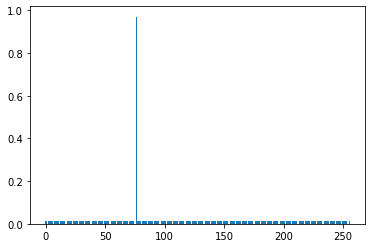

15


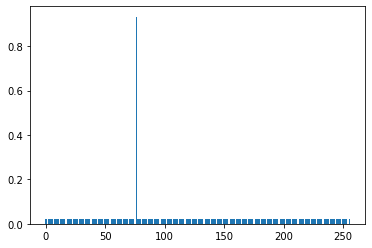

16


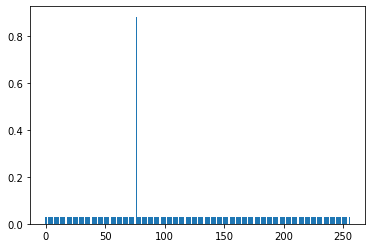

17


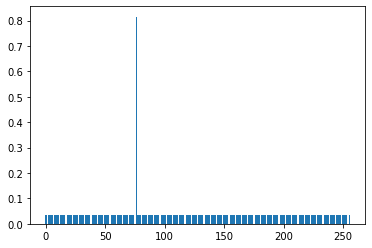

18


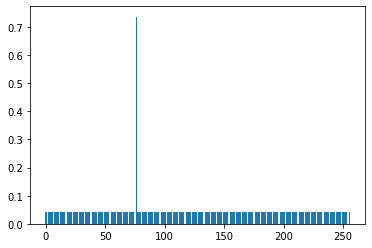

19


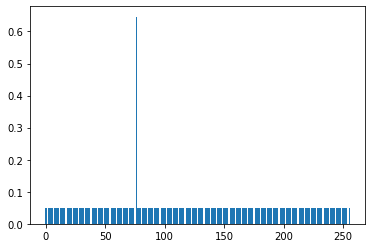

20


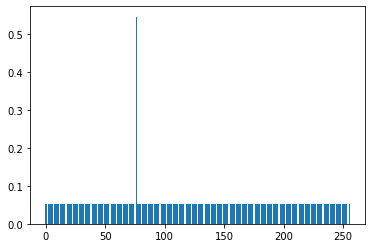

21


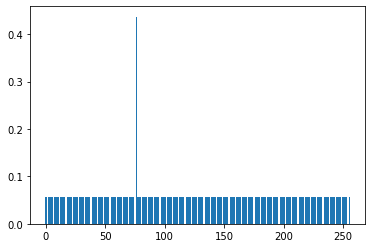

22


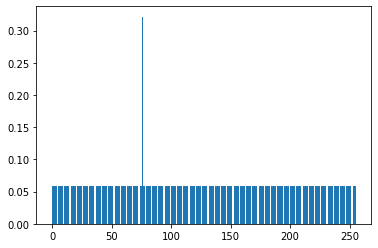

23


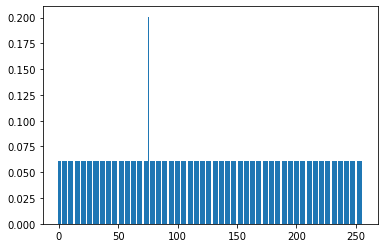

24


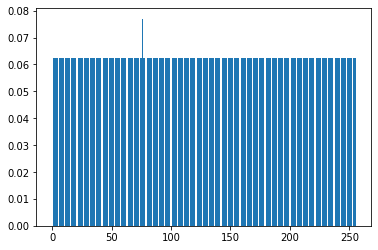

25


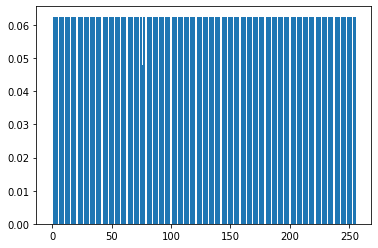

26


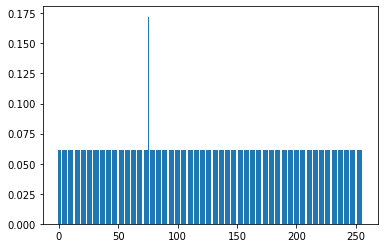

27


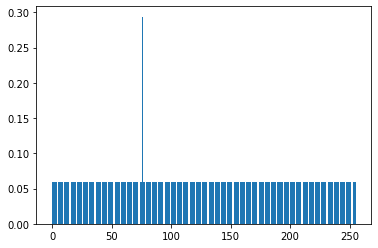

28


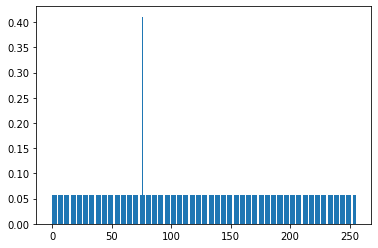

29


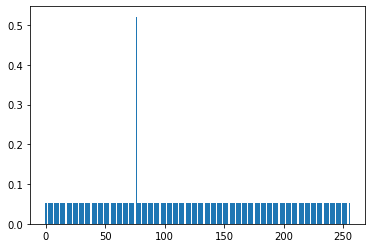

30


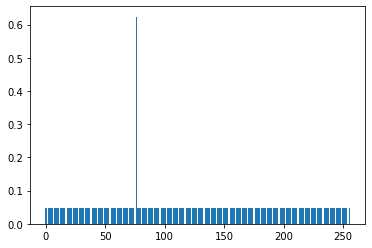

maximal probability 9.999735e-01 is obtained at k = 12
**************************************************
予想されるパスワード(bit)： "01001100"
予想されるパスワード(文字)： "L"
message(crypto): "㋪╥჈⶗㉲O÷Sá×SⓁᆎⳗ㏞⑍Ჿ㡏ځ⤲͇㦍ۛ⤸ʽ㡅偡㏎④ᄴⵗ㏬␉ᆸ⋶ⱉ㈄◍ᇼⵕ㎌◃ဤⵕ㎰⑫㐇鱝㠏گ⤦ኡᆨⱗ洩⿴ⓝ"
復号できた文字列:　"「平文」が欲しいか？欲しけれりゃくれてやる。解いてみろ。この世の<はじまり>をそこに置いてきた。 by Mr.グローバー"
**************************************************


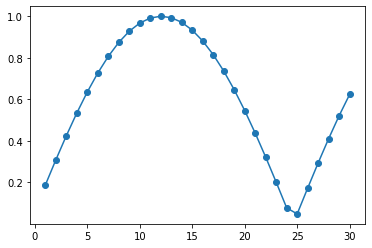

In [11]:
### 実行してみる ###
####################################################
## 好きな値をいれてください(passward は 8bit～16bit(2byteまで)ぐらいが推奨)
password = "L"         # 一文字 8bit #
####################################################

## 暗号の設定を色々
passbit,message,passlen = get_crypto_setting(password)
## 暗号化処理
crypto_bitmessage = quasi_aes(message, 0, passbit)
# print(crypto_bitmessage)
crypto_message = get_crypto_message(crypto_bitmessage)

## 文字変換したときにビットが抜け落ちるのでcrypto_bitmessageを暗号文として運用
## crypto_messageはおまけみたいな感じ

## 設定を出力
print("*"*50)
print("password: \"" + password +"\"")
print("message:　\"" + message +"\"")
print("password(bit):　" + passbit)
print("message(crypto): \"" + crypto_message +"\"")
print("*"*50)

## グローバーのアルゴリズムで探索するために色々
## 初期設定とか
nqubits, bitlist, s, bitint = optimisation_key(passbit)
state = quantum_setup(nqubits)
answer_state = quantum_ans_setup(nqubits, bitint)

## ゲートとか
Hadamard = QuantumCircuit(nqubits)
Hadamard = h_gate(nqubits, Hadamard)
U_w= take_U_w(nqubits, s, bitlist)
U_s = take_U_s(nqubits)

result = []
quantum_list = []

state = quantum_setup(nqubits)
Hadamard.update_quantum_state(state)

## とりあえず30回繰り返す
# 繰り返し回数を変えたい場合は、 
# range(30) と plt.plot(np.arange(1, 30+1).... の「30」を任意の数字に書き換えてください
for k in range(30):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)
    print(str(k+1))
    show_distribution(state,nqubits)
    result.append(np.linalg.norm(inner_product(state, answer_state)))
    test = state.copy()
    quantum_list.append(test.get_vector())

## 一番確率が高かった時の 添え字k と 正解である確率 を出力
max_k = np.argmax(result)
print( f"maximal probability {result[max_k]:5e} is obtained at k = {max_k+1}")
plt.plot(np.arange(1, 30+1), result, "o-")

## 予想できたパスワードを二進数や文字列に変換します
# print(max(quantum_list[max_k]))
pswd = []
c = 0
## 二進数変換したり文字列に直したり
grover_answer = str(format(np.argmax(quantum_list[max_k]),'08b'))
if len(passlen) == 1:
    pswd = chr(int('0b'+ grover_answer, 2))
else:
    for i in range(len(passlen)):
        pswd.append(chr(int('0b'+ grover_answer[c:c+i], 2)))
    pswd = ''.join(pswd)
## 復号化処理
rev_bitmessage = quasi_aes(crypto_bitmessage, 1, grover_answer)
rev_message = []
for i in rev_bitmessage:
    rev_message.append(chr(int('0b'+ i, 2)))
rev_message = ''.join(rev_message)
## 最終的な結果を出力
print("*"*50)
print("予想されるパスワード(bit)： \"" + str(grover_answer) +"\"")
print("予想されるパスワード(文字)： \"" + pswd +"\"")
print("message(crypto): \"" + crypto_message +"\"")
print("復号できた文字列:　\"" + rev_message +"\"")
print("*"*50)

<font color= "#5e5">
----------------------------------------------------------------------------------------------------------------------------------------------------------------
</font>

## <font color= "#5e5">さいごに</font>

いかがでしたでしょうか。  
初めてこのアルゴリズムを知ったときは、衝撃的でしたね。  
私は実際に実装してみて、より鮮明にアルゴリズムを理解できたと自負しております。  
皆さんも、もしよろしければ、ぜひ実装にチャレンジしても見てはいかがでしょうか。  
~~ただ単に筆者が見たいだけですが、~~理解の一助となることは間違いありません。

どうして、なぜそうなるのか、などの質問には答えかねますが、  
この実装を見て、何かヒントのようなものが得ることがあれば、  
筆者も大変喜ばしい限りです。  

では、また、どこかで。Good Luck.

<font color= "#5e5">
----------------------------------------------------------------------------------------------------------------------------------------------------------------
</font>

公開：2021/09/14